In [2]:
import litebird_sim as lbs
import astropy.units as u
import numpy as np


# Inizializzazione della simulazione
sim = lbs.Simulation(
    start_time=0, # in questo modo la rivoluzione della Terra intorno al Sole è modellato utilizzando un moto circolare semplice
    duration_s=60.0, # tempo di durata della simulazione pari a 60s
    description="Simple simulation",
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) # "aiuta" LBS a capire quale IMO usare
)


# Scanning strategy (movimento del satellite)
sim.set_scanning_strategy( 
    scanning_strategy=lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(30), # angolo alpha tra asse di rotazione e asse Sole-Terra (30°)
        spin_rate_hz=0.5 / 60.0,     # rotazione della direzione di puntamento attorno all'asse di rotazione (0,5 rotazioni al minuto)
        precession_rate_hz=1.0 / (4 * u.day).to("s").value, # precessione attorno all'asse Sole-Terra (1 giro completo ogni 4 giorni)
    )
)


# Boresight (telescopio)
sim.set_instrument(
    lbs.InstrumentInfo(
        name="core",
        spin_boresight_angle_rad=np.deg2rad(65), # angolo beta tra l'asse di rotazione e la direzione di puntamento (65°)
    ),
)


# Detector `det` (finto rivelatore)
det = lbs.DetectorInfo(name="foo", sampling_rate_hz=10) # fa 10 misure ogni secondo


# Osservazione e calcolo delle direzioni

obs, = sim.create_observations(detectors=[det]) # create_observations() crea una sola osservazione

sim.prepare_pointings() # prepara i quaternioni necessari per calcolare i pointing, cioè la direzione nel cielo verso cui guarda il detector in funzione del tempo

pointings, _ = obs.get_pointings(0) # get_pointings() restituisce la matrice dei pointing e l'angolo HWP (qui lo ignoriamo perchè non c'è)
                                    # la matrice dei pointing contiene gli angoli (θ, φ, ψ) per ogni campione nel TOD e per ogni detector


print("Shape:", pointings.shape)
print("Pointings:")
print(np.array_str(pointings, precision=3))

Shape: (600, 3)
Pointings:
[[ 2.182 -0.    -1.571]
 [ 2.182 -0.006 -1.576]
 [ 2.182 -0.012 -1.582]
 ...
 [ 0.089 -2.967 -1.738]
 [ 0.088 -3.021 -1.687]
 [ 0.087 -3.075 -1.635]]


### Matrice di pointing
Forma: 600 righe * 3 colonne
- 600 righe = 60s * 10 misure/s = 600 misurazioni
- 3 colonne = ($\theta$, $\phi$, $\psi$) = coordinate celesti
  - $\theta$ colatitudine
  - $\phi$ longitudine
  - $\psi$ orientamento



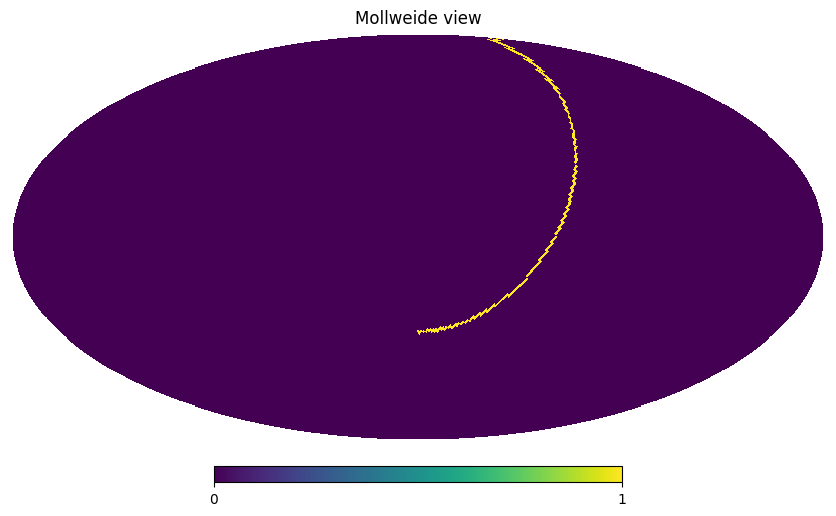

In [4]:
import healpy, numpy as np
import matplotlib.pylab as plt

nside = 64 # Definizione della risoluzione
pixidx = healpy.ang2pix(nside, pointings[:, 0], pointings[:, 1]) # Conversione da coordinate a indici pixel
m = np.zeros(healpy.nside2npix(nside)) # Creazione di una mappa vuota
m[pixidx] = 1 # Marcatura dei pixel osservati
healpy.mollview(m)

# Mostra le direzioni di puntamento del telescopio 